In [1]:
from astropy.table import Table,QTable

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')

from mass_ratio_plottingFunctions import DM_SM_hist, DM_SM_hist_std, median_hist

import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
#IMAGE_DIR = 'C:/Users/jacob/Documents/GitHub/RotationCurves/images/'
IMAGE_DIR = '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/images/'

#master_table = Table.read( 'C:/Users/jacob/Documents/GitHub/RotationCurves/master_file.txt', format='ascii.ecsv')
#wrong_master_table = QTable.read('../spirals/WRONG-master_file_vflag_10_smooth2-27.txt', format='ascii.ecsv')
#master_table = QTable.read('../spirals/Pipe3D-master_file_vflag_10_smooth2-27.txt', format='ascii.ecsv')
#master_table = Table.read('../spirals/Pipe3D-master_file_vflag_10_smooth2p27_N2O2_noWords.txt', 
master_table = Table.read('../spirals/Pipe3D-master_file_vflag_BB_minimize_chi10_smooth2p27_mapFit_N2O2_noWords.txt', 
                          format='ascii.commented_header')

#### Remove bad galaxies

In [3]:
bad_boolean = np.logical_or(master_table['M90_map'] == -99, master_table['M90_disk_map'] == -99)

good_galaxies = master_table[np.logical_not(bad_boolean)]

#### Calculate $M_{90}/M_{90, disk}$

In [4]:
good_galaxies['M90_Mdisk_ratio'] = 10**good_galaxies['M90_map']/10**good_galaxies['M90_disk_map']

#### Split galaxies into "walls" and "voids"

In [5]:
vboolean = good_galaxies['vflag'] == 1
wboolean = good_galaxies['vflag'] == 0

void_table = good_galaxies[vboolean]
wall_table = good_galaxies[wboolean]

### Histogram parameters

In [6]:
hist_range = (0, 30)
bins = np.arange( hist_range[0], hist_range[1], 1.5)

### Initialize table to store the number of galaxies in each bin of the histogram(s)

In [7]:
count_table = Table()

# First column is the bins
count_table['Bins'] = bins[1:]

## Function to calculate shift between populations

In [8]:
def calculate_shift(void_ratios, wall_ratios, void_ratio_errors, wall_ratio_errors):
    '''
    Calculate the average shift between the void and wall populations.
    
    
    Parameters:
    ===========
    
    void_ratios : numpy array of shape (n_void,)
        Array of the mass ratios for the void galaxies
        
    wall_ratios : numpy array of shape (n_wall,)
        Array of the mass ratios for the wall galaxies
        
    void_ratio_errors : numpy array of shape (n_void,)
        Array of the errors in the mass ratios for the void galaxies
        
    wall_ratio_errors : numpy array of shape (n_wall,)
        Array of the errors in the mass ratios for the wall galaxies
    '''
    #######################################################################
    # Calculate averages, shift between voids and walls
    #----------------------------------------------------------------------
    v_mean = np.mean(void_ratios)
    w_mean = np.mean(wall_ratios)

    v_median = np.median(void_ratios)
    w_median = np.median(wall_ratios)

    mean_diff = v_mean - w_mean
    median_diff = v_median - w_median
    #######################################################################


    #######################################################################
    # Calculate uncertainties in the averages and shifts
    #----------------------------------------------------------------------
    # Preserve only finite elements for error calculation
    v_finite = void_ratio_errors[np.isfinite(void_ratio_errors)]
    w_finite = wall_ratio_errors[np.isfinite(wall_ratio_errors)]

    v_mean_err = np.sqrt(np.sum(v_finite**2))/len(v_finite)
    w_mean_err = np.sqrt(np.sum(w_finite**2))/len(w_finite)

    mean_diff_err = np.sqrt(v_mean_err**2 + w_mean_err**2)
    #######################################################################


    print('There are', len(void_ratios), 'void galaxies and', len(wall_ratios), 'wall galaxies in this sample.')
    print('The average ratio for voids is', v_mean, 'pm', v_mean_err, 'and for walls is', w_mean, 'pm', w_mean_err)
    print('The average difference between the two populations is', mean_diff, 'pm', mean_diff_err)
    print('The median ratio for voids is', v_median, 'and for walls is', w_median)
    print('The median difference between the two populations is', median_diff)

# Histogram of ratio of dark matter halo mass to stellar mass for all galaxies

There are 781 void galaxies and 1187 wall galaxies in this sample.
The average ratio for voids is 1170.3908787788027 pm 0.6197644808821335 and for walls is 800.2037466608892 pm 0.5374375077459818
The average difference between the two populations is 370.1871321179135 pm 0.8203335214992209
The median ratio for voids is 9.440189457367921 and for walls is 10.441553864097509
The median difference between the two populations is -1.0013644067295875


<IPython.core.display.Javascript object>


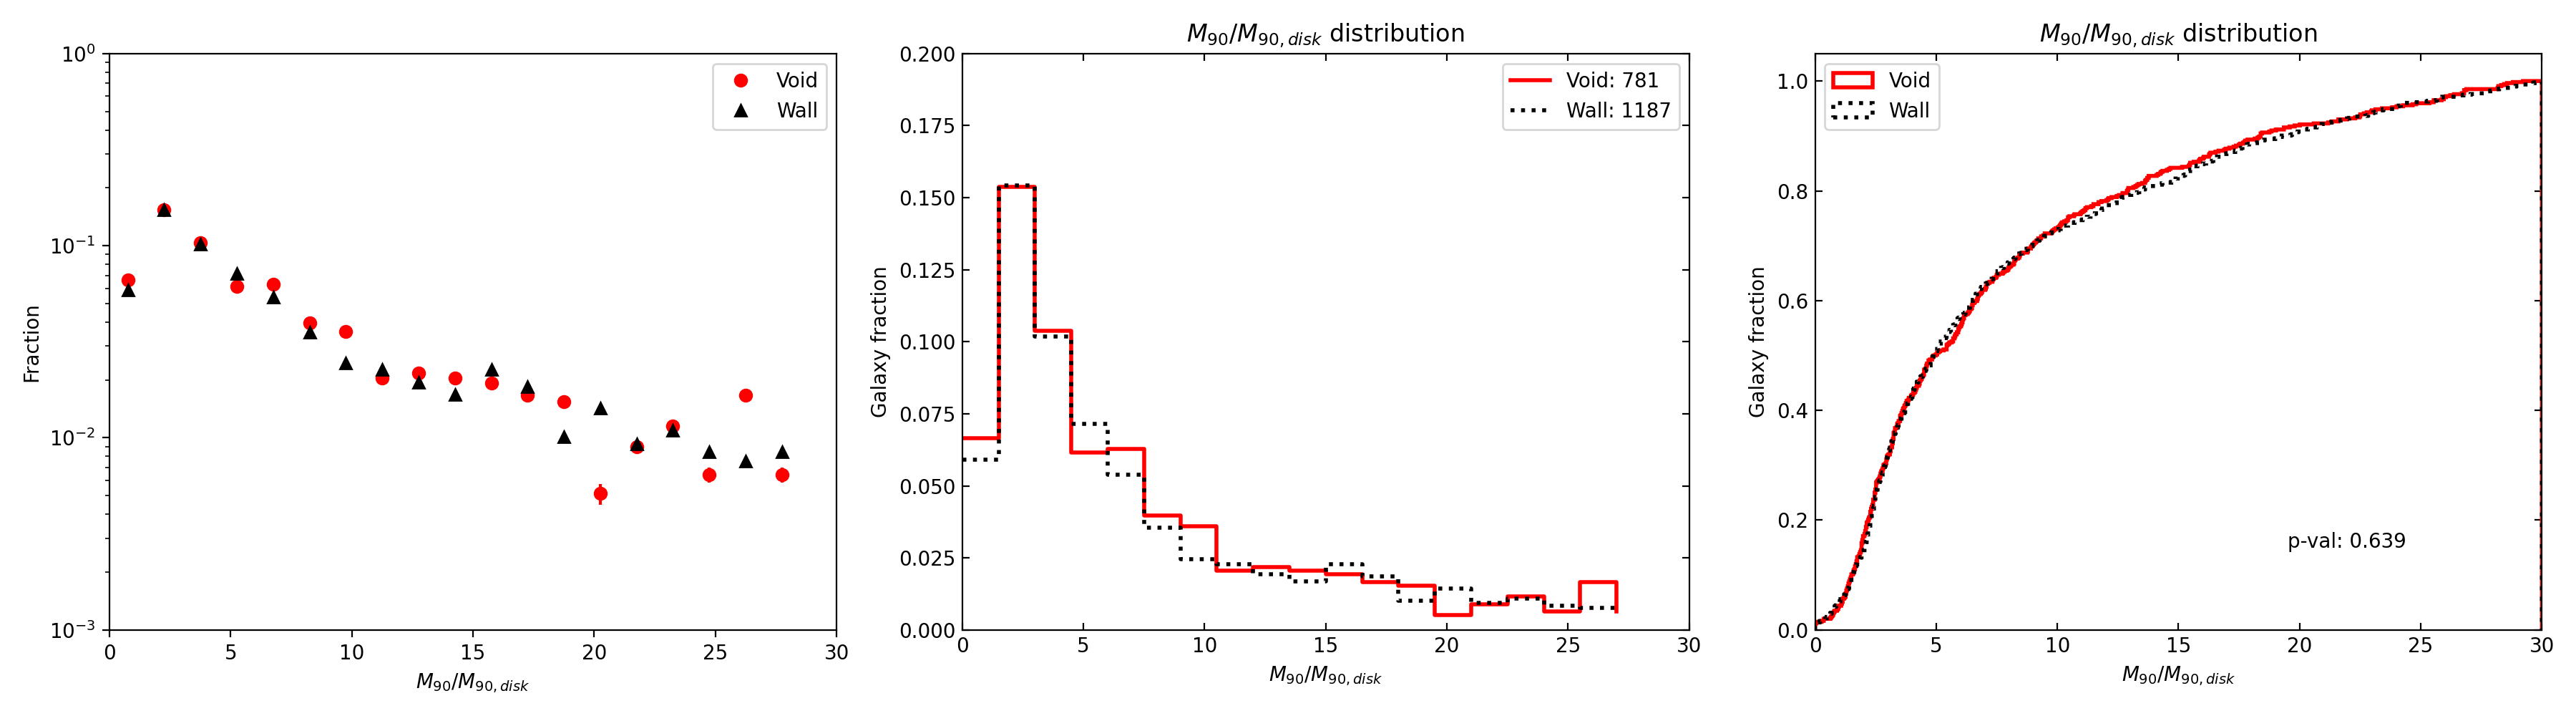

In [9]:
#print('Wrong mass ratios')
#calculate_shift(wrong_void_table['Mdark_Mstar_ratio'], wrong_wall_table['Mdark_Mstar_ratio'],
#                wrong_void_table['Mdark_Mstar_ratio_error'], wrong_wall_table['Mdark_Mstar_ratio_error'])

#print('\nCorrect mass ratios')
calculate_shift(void_table['M90_Mdisk_ratio'], 
                wall_table['M90_Mdisk_ratio'], 
                void_table['M90_err_map'], 
                wall_table['M90_err_map'])

DM_SM_hist(void_table['M90_Mdisk_ratio'], 
           wall_table['M90_Mdisk_ratio'], 
           bins, hist_range, y_max=0.2, 
           plot_title='$M_{90}/M_{90, disk}$ distribution', 
           x_label='$M_{90}/M_{90, disk}$');#, save_fig=True, FILE_SUFFIX='_all', IMAGE_DIR=IMAGE_DIR)

# Bin by absolute magnitude

In [11]:
def mag_bin_results(ctable, vtable, wtable, Mmin, Mmax, bin_array, bin_range):
    
    vboolean = np.logical_and(vtable['rabsmag'].data < Mmin, 
                              vtable['rabsmag'].data >= Mmax)
    wboolean = np.logical_and(wtable['rabsmag'].data < Mmin, 
                              wtable['rabsmag'].data >= Mmax)
    
    
    #######################################################################
    # Separate the mass ratios according to wall or void.
    #----------------------------------------------------------------------
    wall_ratio = wtable['M90_Mdisk_ratio'][wboolean].data
    void_ratio = vtable['M90_Mdisk_ratio'][vboolean].data

    wall_ratio_err = wtable['M90_err_map'][wboolean].data
    void_ratio_err = vtable['M90_err_map'][vboolean].data

    #Mrange_wall_table = wtable[wboolean]
    #Mrange_void_table = vtable[vboolean]
    #######################################################################
    
    
    #######################################################################
    # Add population counts to histogram table
    #----------------------------------------------------------------------
    ctable['v'+str(Mmin)+str(Mmax)], _ = np.histogram(void_ratio, bin_array)
    ctable['w'+str(Mmin)+str(Mmax)], _ = np.histogram(wall_ratio, bin_array)
    #######################################################################
    
    
    calculate_shift(void_ratio, wall_ratio, void_ratio_err, wall_ratio_err)

    DM_SM_hist(void_ratio, wall_ratio, bin_array, bin_range, y_max=0.7, 
               plot_title=str(Mmin) + ' $> M_r >$ ' + str(Mmax), 
               x_label='$M_{90}/M_{90, disk}$')
               #save_fig=True, FILE_SUFFIX='_17-18', IMAGE_DIR=IMAGE_DIR)

### Dwarf galaxies ($M_r > -17$)

There are 7 void galaxies and 2 wall galaxies in this sample.
The average ratio for voids is 215.59952834065854 pm 4.289990381147527 and for walls is 88.25298229354009 pm 7.621137255879564
The average difference between the two populations is 127.34654604711845 pm 8.745613217110266
The median ratio for voids is 96.49871767755035 and for walls is 88.25298229354009
The median difference between the two populations is 8.24573538401026


<IPython.core.display.Javascript object>


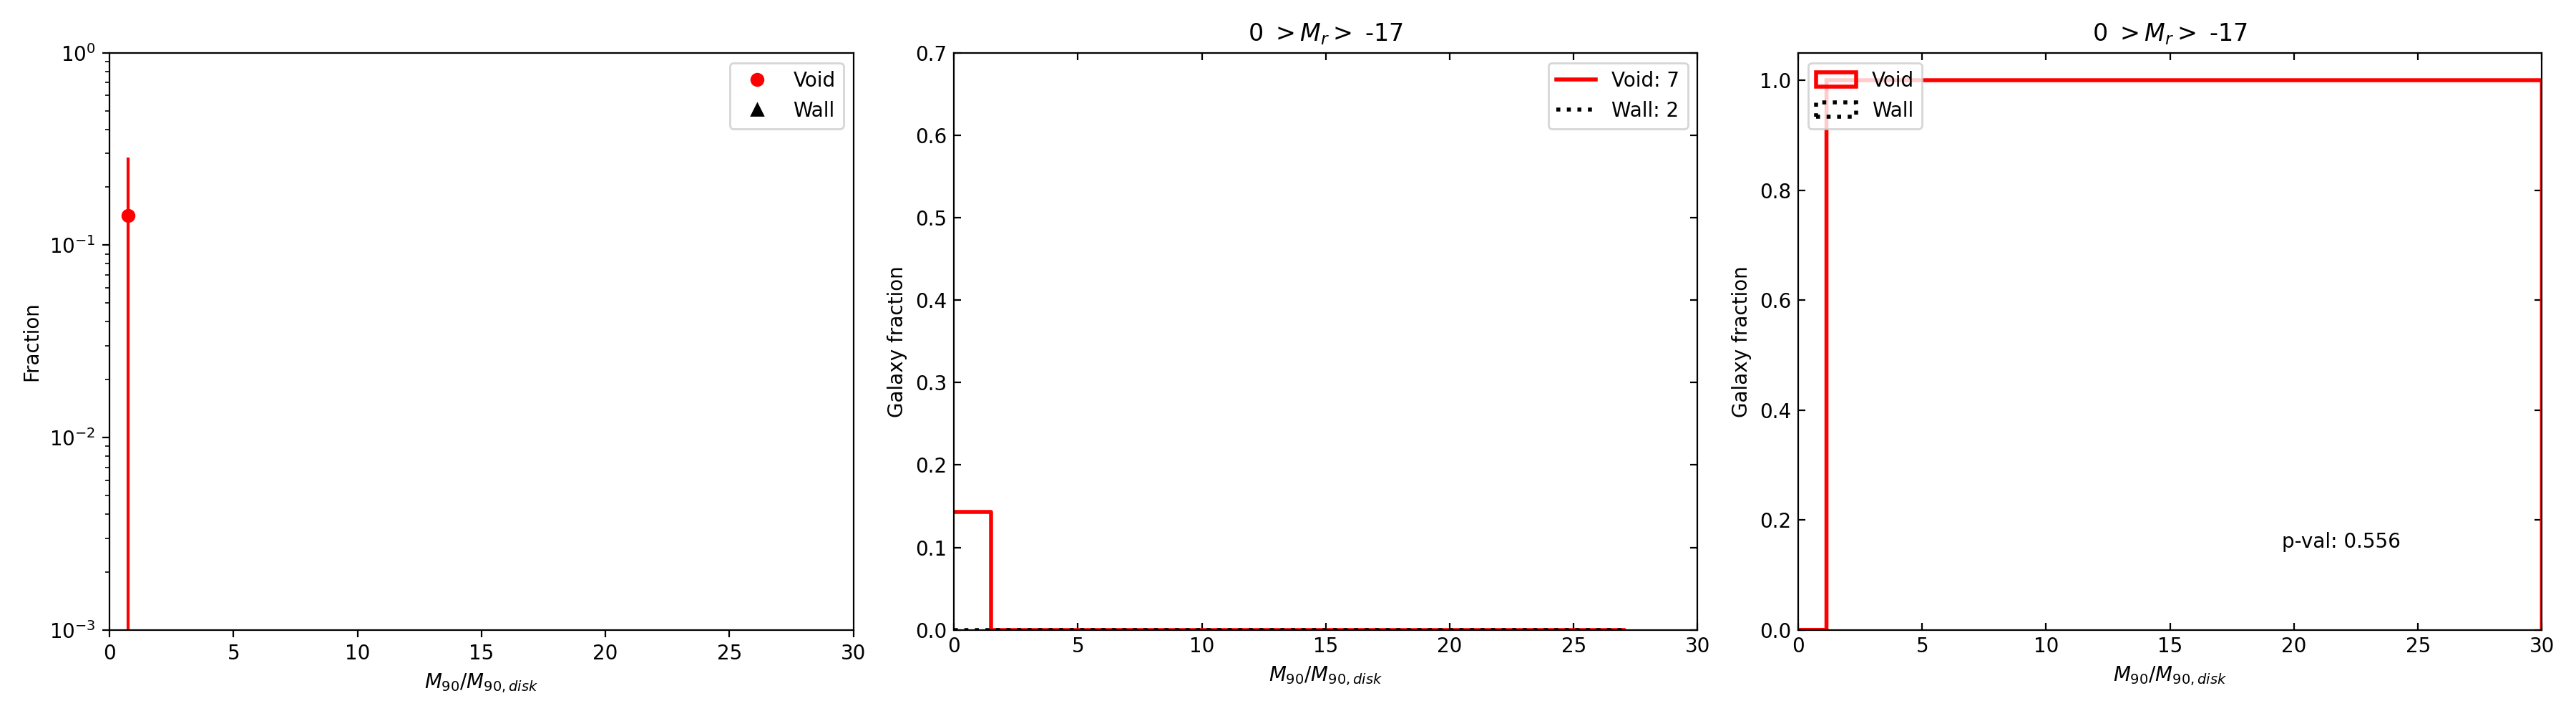

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [12]:
mag_bin_results(count_table, void_table, wall_table, 0, -17, bins, hist_range)

### Galaxies between -17 and -18 in $M_r$

There are 93 void galaxies and 92 wall galaxies in this sample.
The average ratio for voids is 1825.2740179567206 pm 1.1510435580728364 and for walls is 1123.0639157846103 pm 2.4356976691712937
The average difference between the two populations is 702.2101021721103 pm 2.6939792887450804
The median ratio for voids is 31.34224531070145 and for walls is 22.563940605714144
The median difference between the two populations is 8.778304704987306


<IPython.core.display.Javascript object>


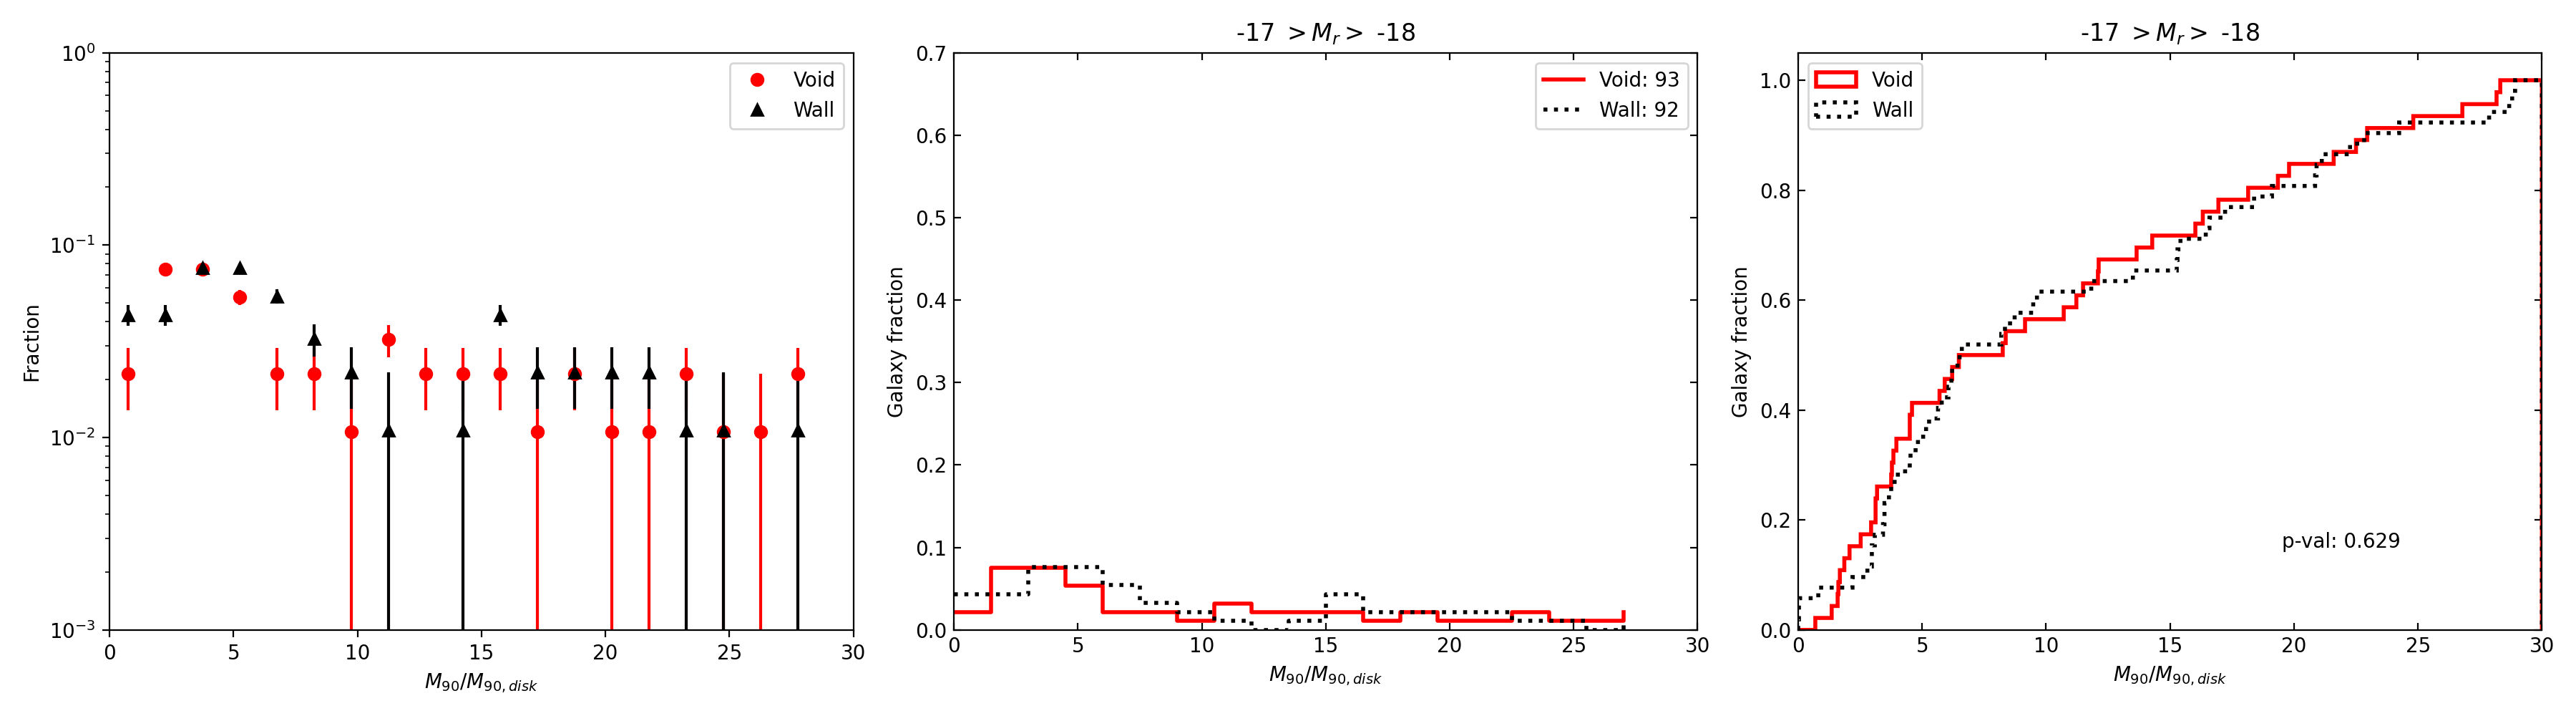

In [13]:
mag_bin_results(count_table, void_table, wall_table, -17, -18, bins, hist_range)

### Galaxies fainter than -18 in $M_r$

There are 100 void galaxies and 94 wall galaxies in this sample.
The average ratio for voids is 1712.5968036835964 pm 1.1117944037725425 and for walls is 1101.0466618805451 pm 2.3893827596139463
The average difference between the two populations is 611.5501418030512 pm 2.635381712048617
The median ratio for voids is 34.170974474863016 and for walls is 23.550974298329884
The median difference between the two populations is 10.620000176533132


<IPython.core.display.Javascript object>


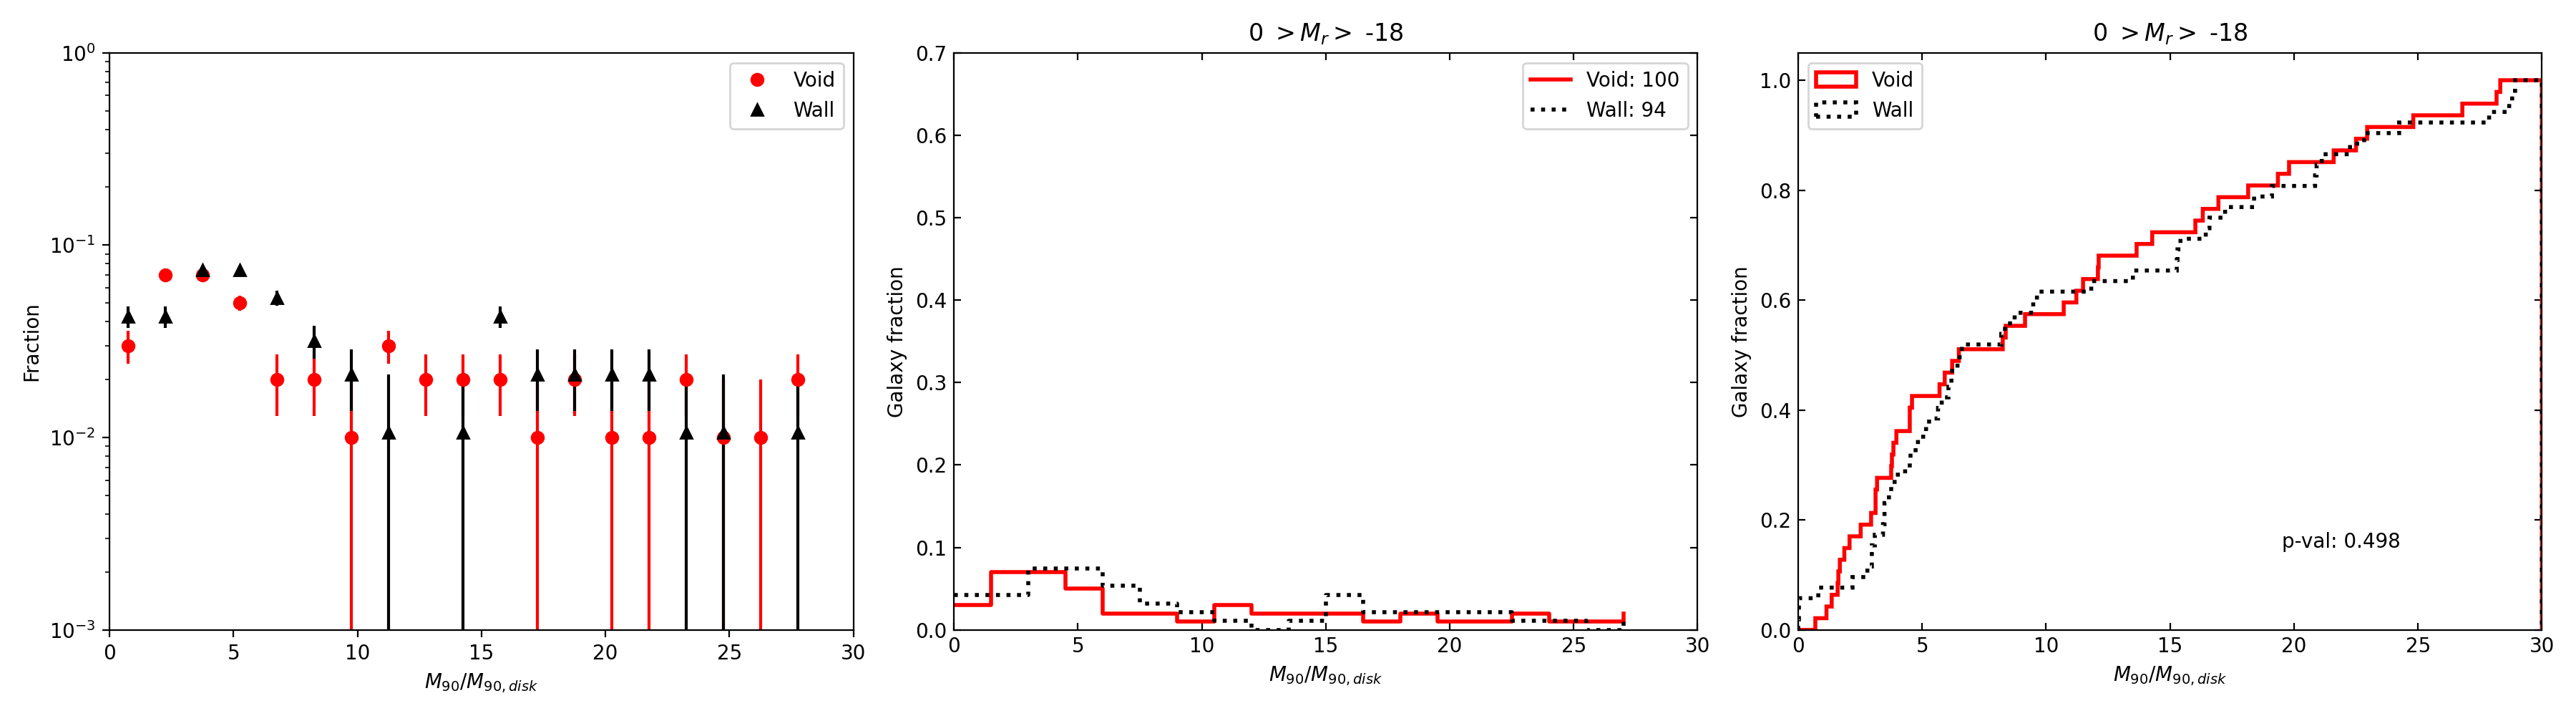

In [14]:
mag_bin_results(count_table, void_table, wall_table, 0, -18, bins, hist_range)

### Galaxies between -18 and -19 in $M_r$

There are 193 void galaxies and 248 wall galaxies in this sample.
The average ratio for voids is 334.3802019997697 pm 1.4824767051194654 and for walls is 2878.7248808203653 pm 1.1385445547723025
The average difference between the two populations is -2544.3446788205956 pm 1.8692300244816118
The median ratio for voids is 13.315714575718264 and for walls is 14.564368601475575
The median difference between the two populations is -1.248654025757311


<IPython.core.display.Javascript object>


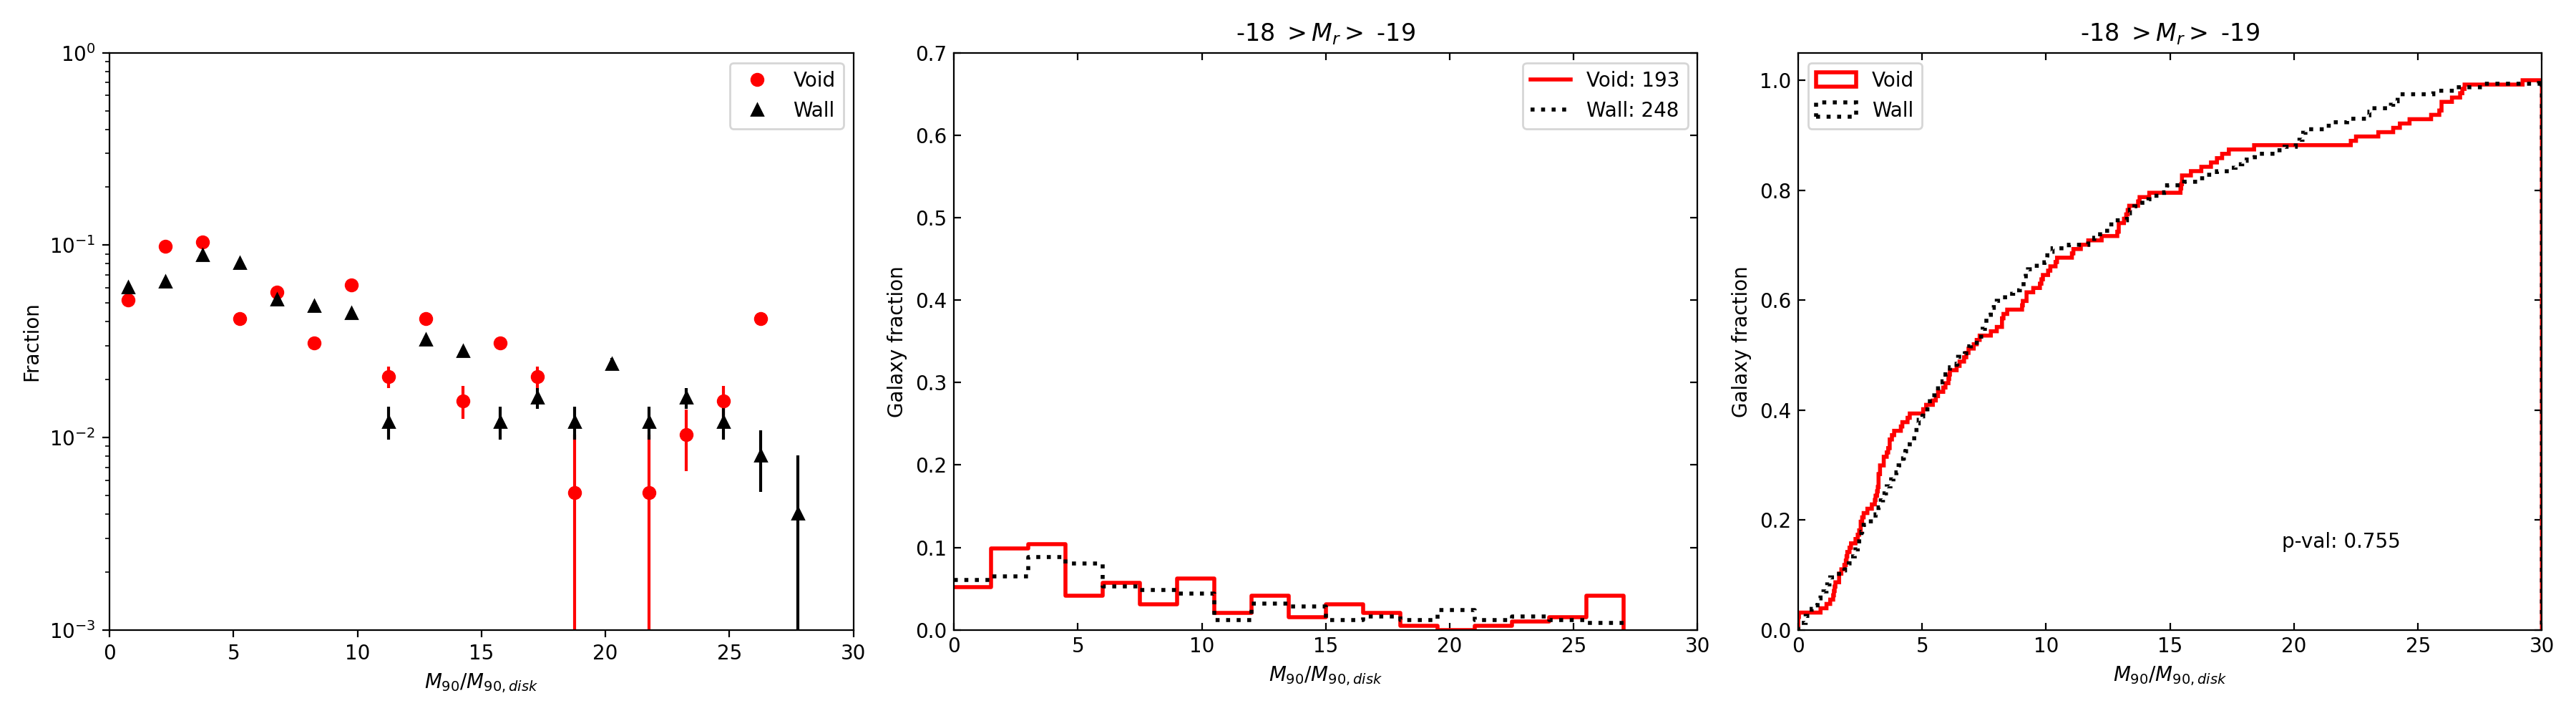

In [15]:
mag_bin_results(count_table, void_table, wall_table, -18, -19, bins, hist_range)

### Galaxies between -19 and -20 in $M_r$

There are 194 void galaxies and 302 wall galaxies in this sample.
The average ratio for voids is 313.2278219179096 pm 1.1818254722863302 and for walls is 116.52018957376288 pm 1.2577380347820566
The average difference between the two populations is 196.7076323441467 pm 1.7258668578665728
The median ratio for voids is 7.0114819968193896 and for walls is 8.696464535850009
The median difference between the two populations is -1.684982539030619


<IPython.core.display.Javascript object>


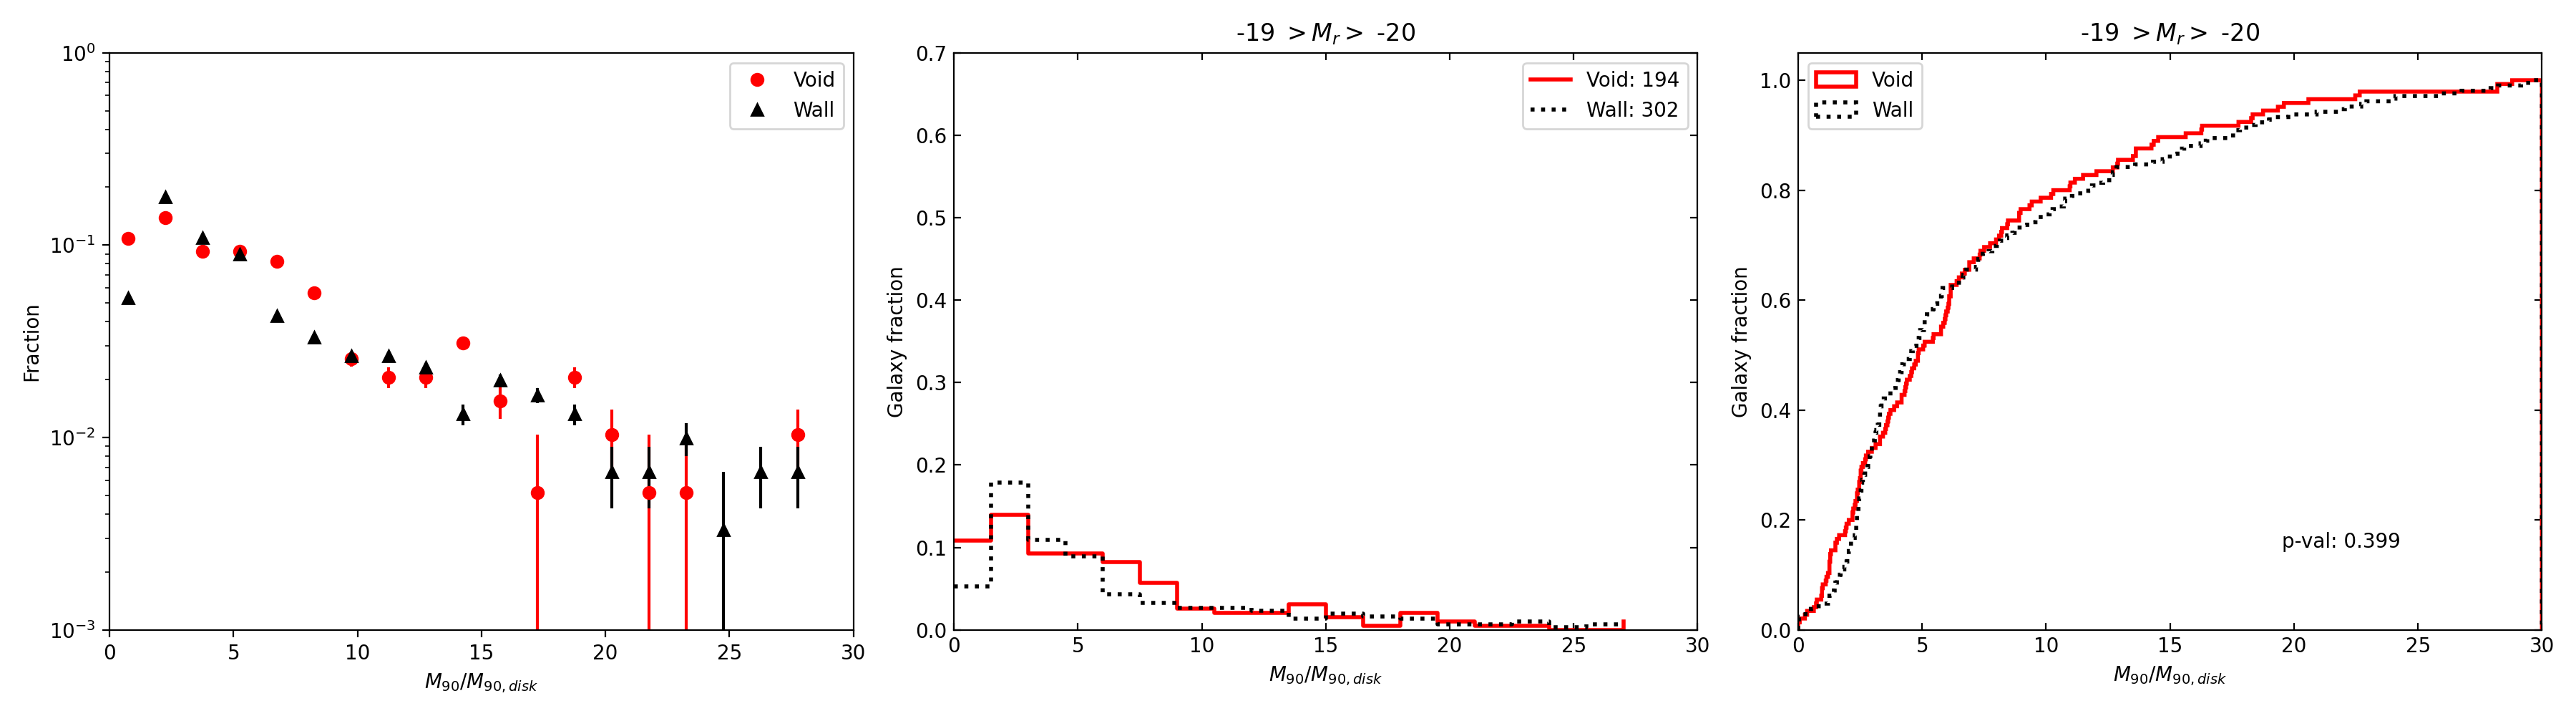

In [16]:
mag_bin_results(count_table, void_table, wall_table, -19, -20, bins, hist_range)

### Galaxies with $M_r < -20$

There are 294 void galaxies and 543 wall galaxies in this sample.
The average ratio for voids is 2100.3878214961064 pm 1.006135412241677 and for walls is 179.06186625226022 pm 0.6704019162615928
The average difference between the two populations is 1921.3259552438462 pm 1.209027376486548
The median ratio for voids is 6.716749420597473 and for walls is 7.96035104655729
The median difference between the two populations is -1.2436016259598164


<IPython.core.display.Javascript object>


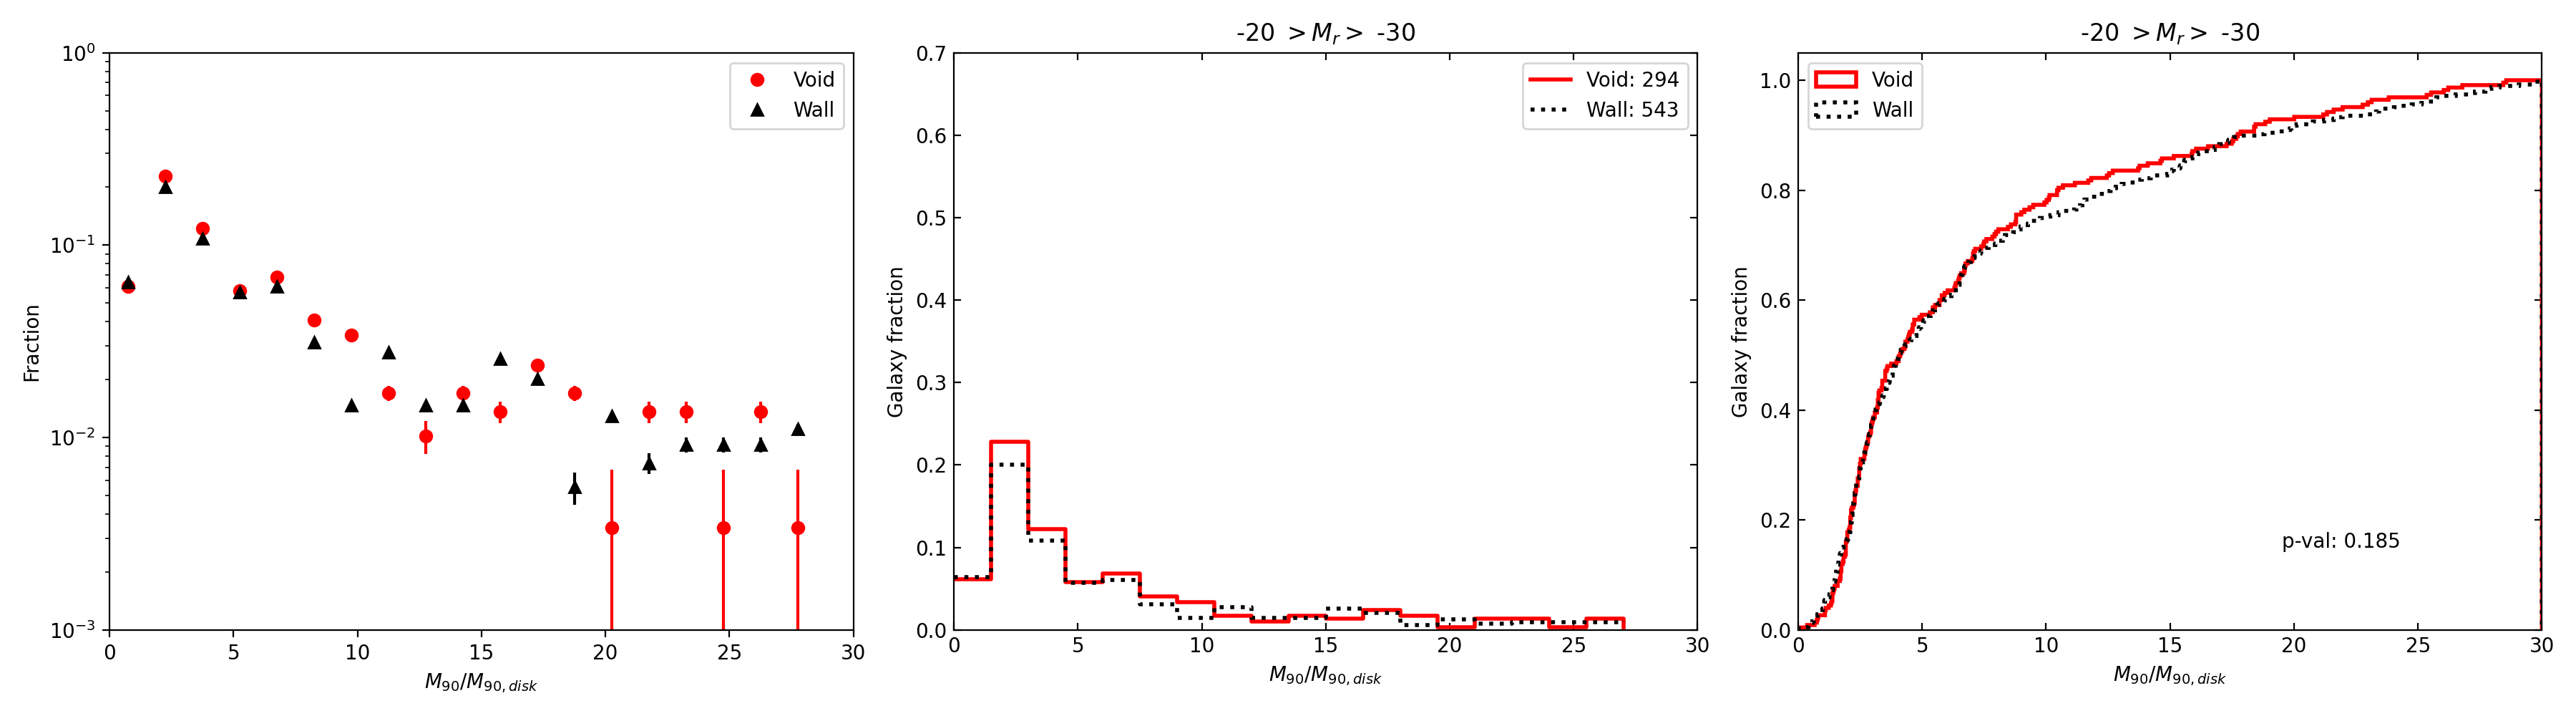

In [17]:
mag_bin_results(count_table, void_table, wall_table, -20, -30, bins, hist_range)

### Galaxies between -20 and -21 in $M_r$

There are 172 void galaxies and 284 wall galaxies in this sample.
The average ratio for voids is 57.361002582616976 pm 1.432901595442906 and for walls is 140.2899761776591 pm 1.0294744091482875
The average difference between the two populations is -82.92897359504212 pm 1.76437653048153
The median ratio for voids is 6.457472527812193 and for walls is 6.804349233281979
The median difference between the two populations is -0.34687670546978566


<IPython.core.display.Javascript object>


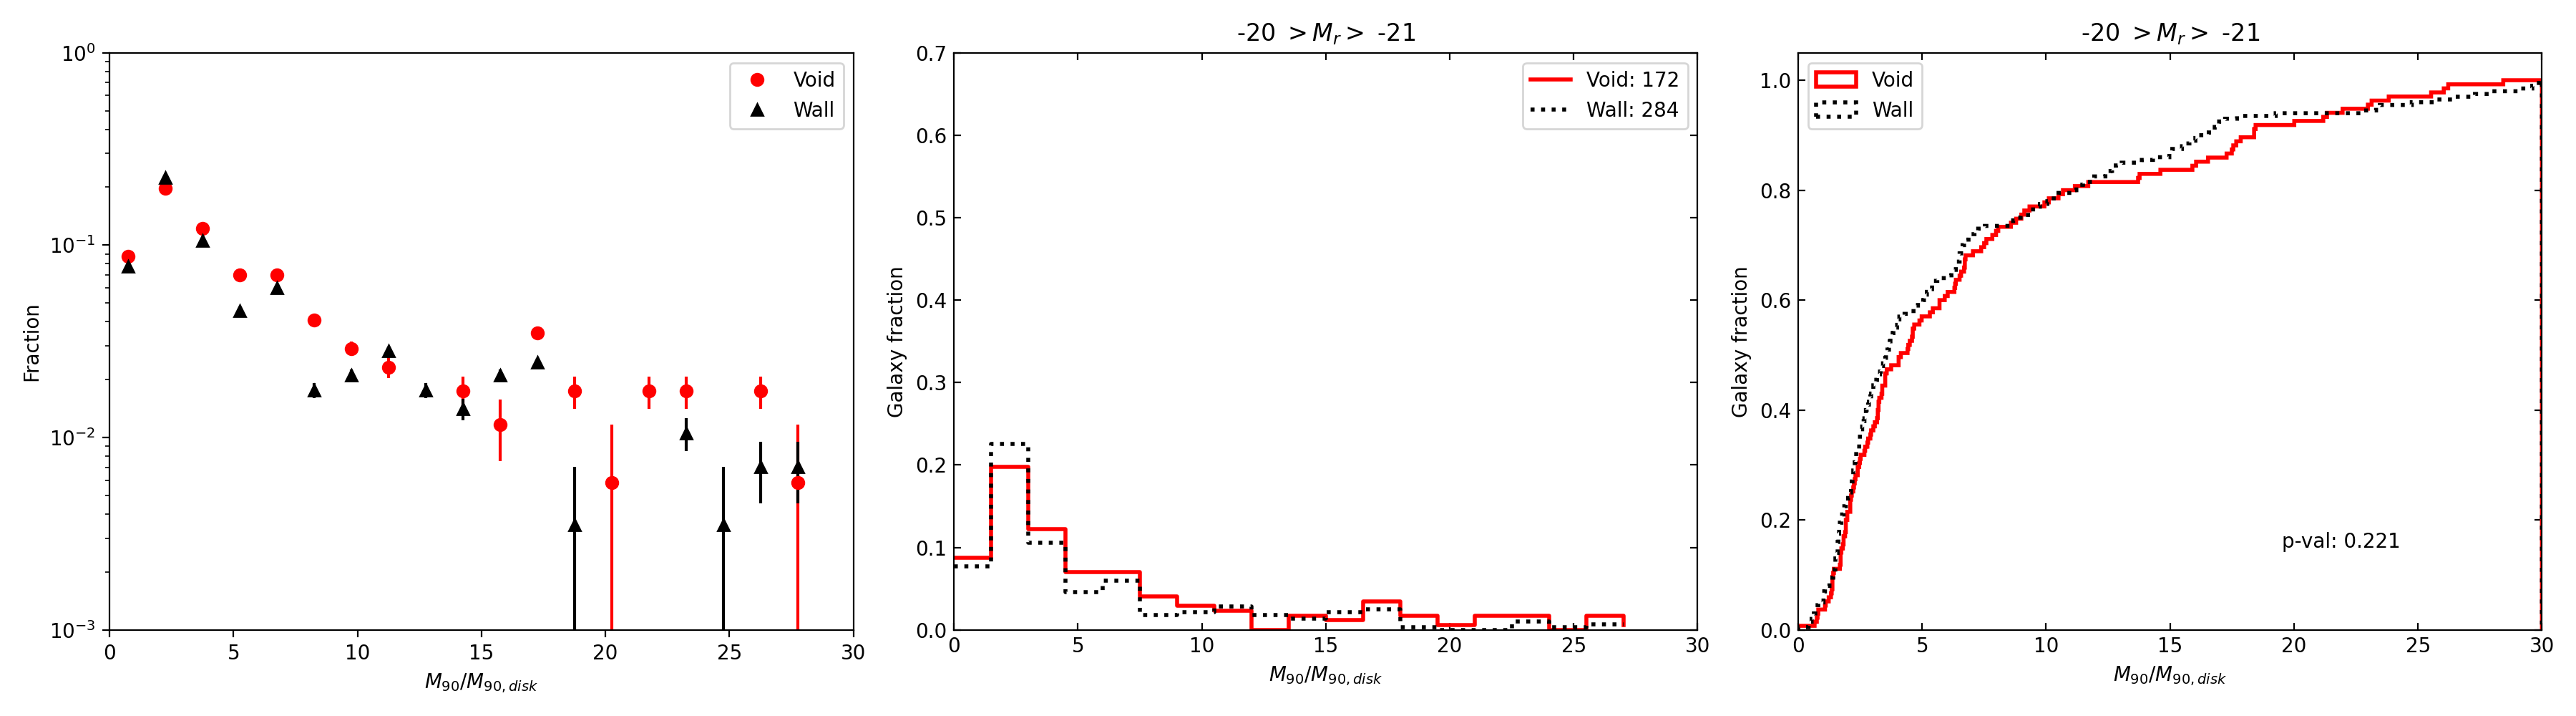

In [18]:
mag_bin_results(count_table, void_table, wall_table, -20, -21, bins, hist_range)

### Galaxies with $M_r < -21$

There are 122 void galaxies and 259 wall galaxies in this sample.
The average ratio for voids is 4980.720713734797 pm 1.340804713652781 and for walls is 221.5762167587727 pm 0.8373654421267273
The average difference between the two populations is 4759.144496976024 pm 1.5808030123394898
The median ratio for voids is 7.076835653063626 and for walls is 8.321244304222926
The median difference between the two populations is -1.2444086511592998


<IPython.core.display.Javascript object>


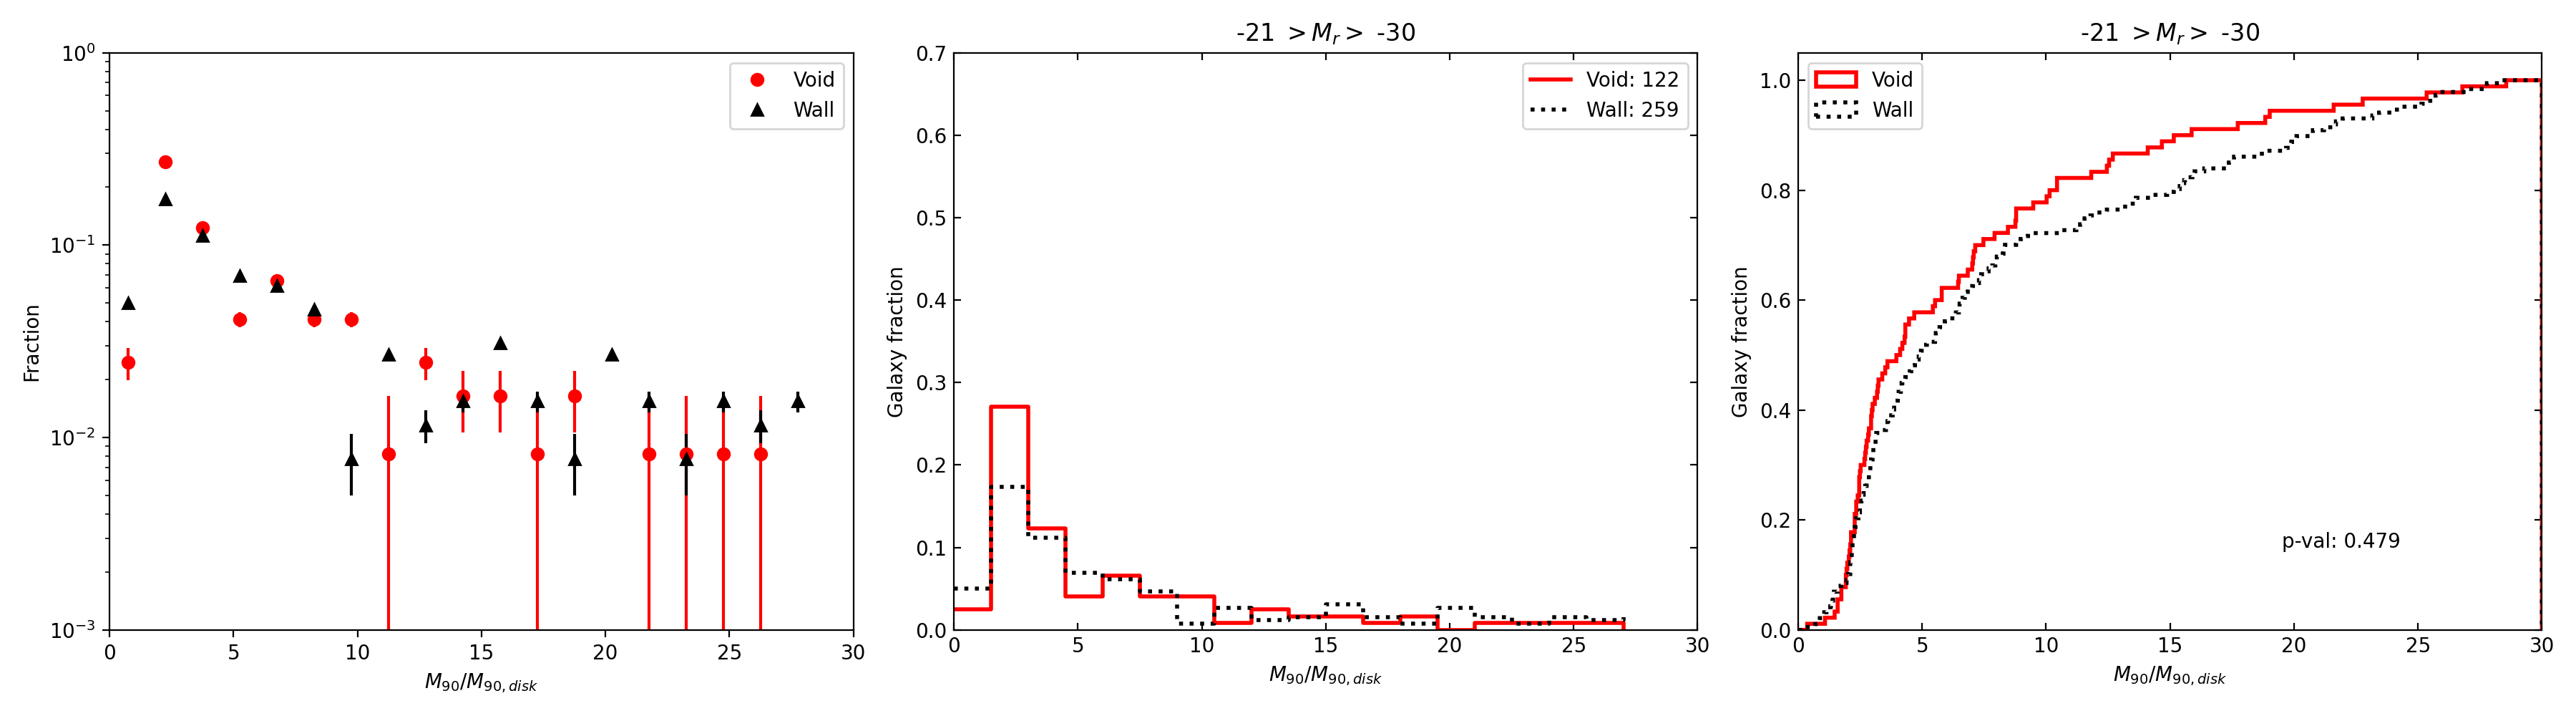

In [19]:
mag_bin_results(count_table, void_table, wall_table, -21, -30, bins, hist_range)

## Mass ratio v. $M_r$

In [20]:
from statsmodels.nonparametric.smoothers_lowess import lowess

### Local linear regression of data

In [21]:
void_smooth = lowess(void_table['M90_Mdisk_ratio'], void_table['rabsmag'], frac=0.25)
wall_smooth = lowess(wall_table['M90_Mdisk_ratio'], wall_table['rabsmag'], frac=0.25)

<IPython.core.display.Javascript object>


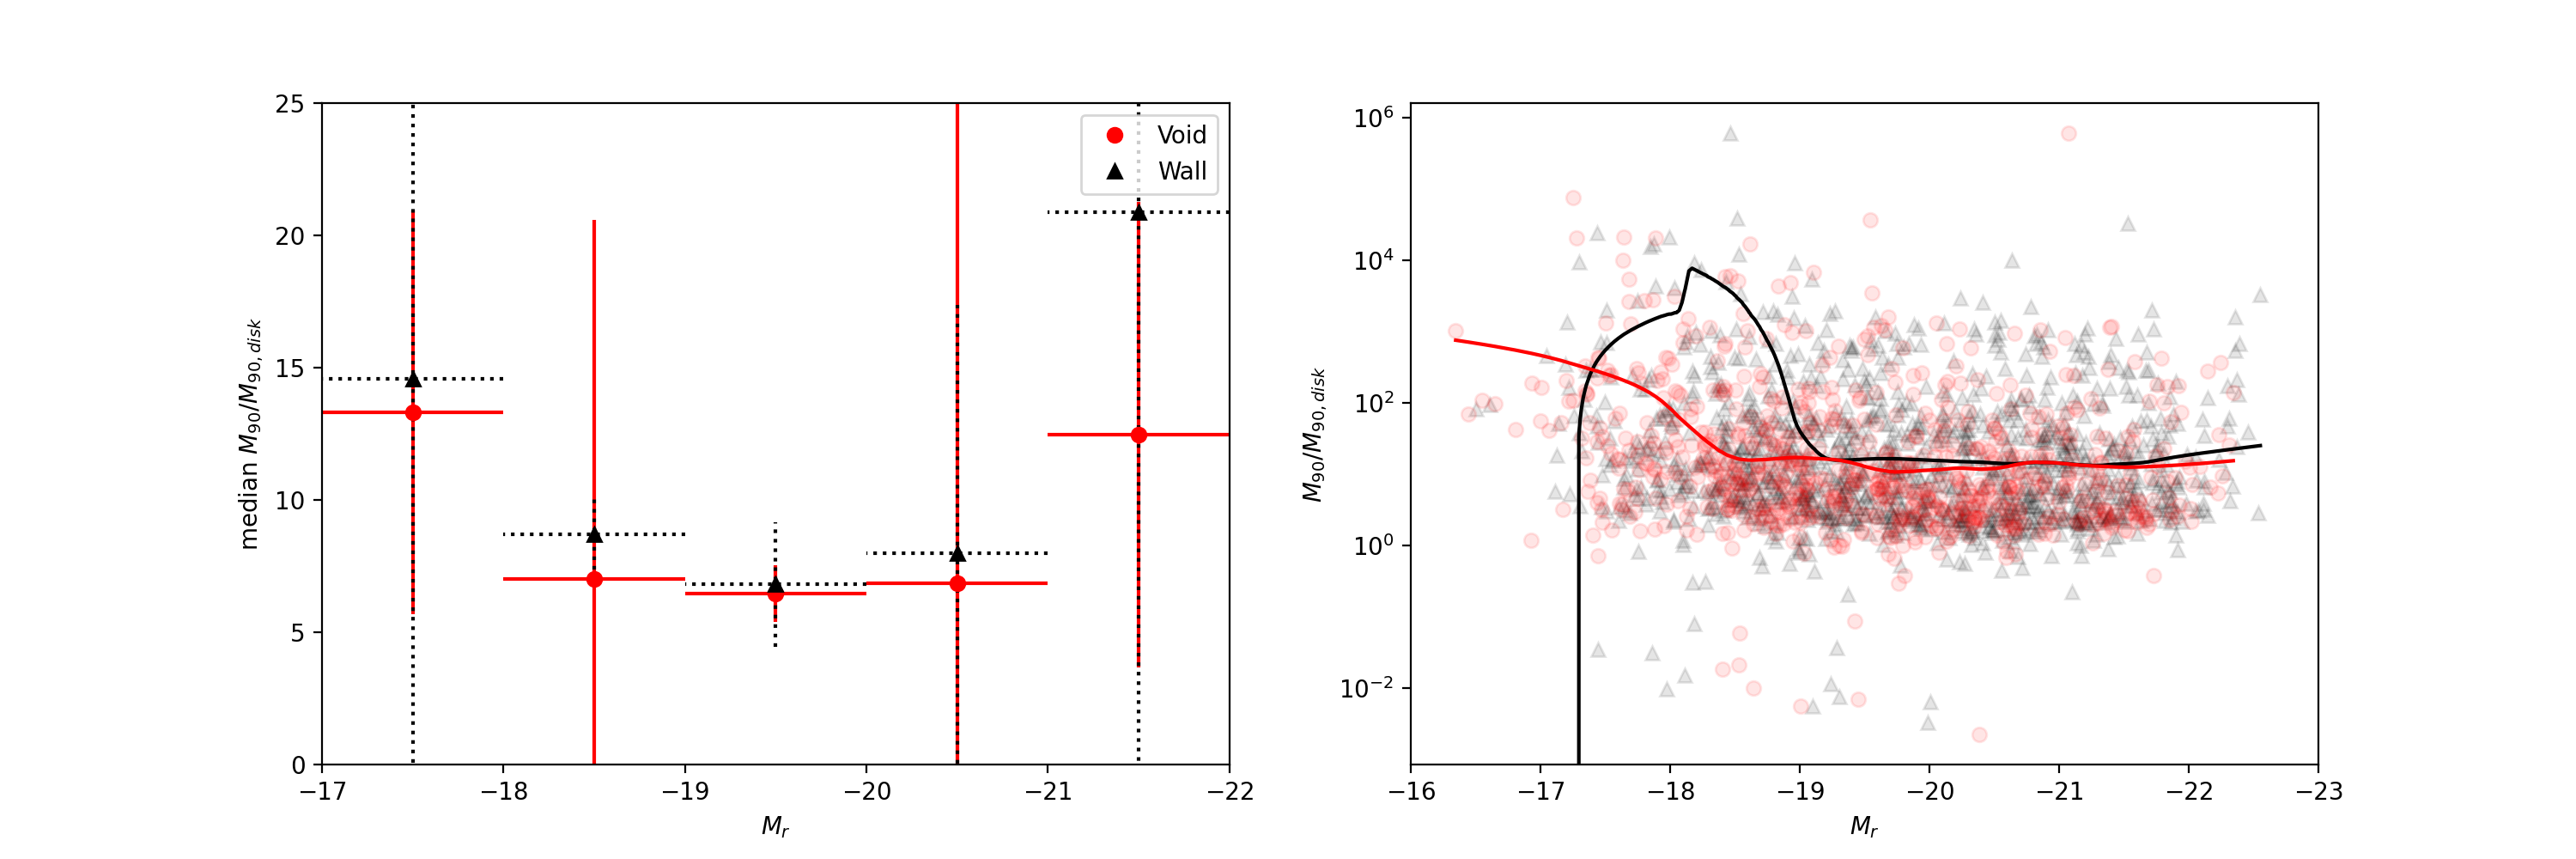

In [23]:
%matplotlib notebook

plt.figure(figsize=(15,5))

plt.subplot(121)

median_hist(void_table, wall_table, 'rabsmag', 'M90_Mdisk_ratio', 
            np.array([-22, -21, -20, -19, -18]))

plt.xlim(-17,-22)
plt.ylim(0,25)
'''
plt.semilogy(wrong_wall_table['rabsmag'], wrong_wall_table['Mdark_Mstar_ratio'],
             'k^', alpha=0.3)
plt.semilogy(wrong_void_table['rabsmag'], wrong_void_table['Mdark_Mstar_ratio'],
             'ro', alpha=0.3)
             
plt.xlim(-16,-23)

plt.xlabel('$M_r$')
plt.ylabel('$M_{DM}$/$M_*$')
'''


plt.subplot(122)

plt.semilogy(wall_table['rabsmag'], wall_table['M90_Mdisk_ratio'], 'k^', alpha=0.1)
plt.semilogy(void_table['rabsmag'], void_table['M90_Mdisk_ratio'], 'ro', alpha=0.1)

plt.semilogy(wall_smooth[:,0], wall_smooth[:,1], 'k')
plt.semilogy(void_smooth[:,0], void_smooth[:,1], 'r')

plt.xlim(-16,-23)

plt.xlabel('$M_r$')
plt.ylabel('$M_{90}$/$M_{90, disk}$');

## Write histogram table to file

In [ ]:
count_table.write('histogram_counts.txt', format='ascii.commented_header')

## Statistics

In [ ]:
g20_void_table.sort('Mdark_Mstar_ratio')
g20_wall_table.sort('Mdark_Mstar_ratio')

print(sum(g20_void_table['Mdark_Mstar_ratio'] > 1E4))
print(sum(g20_wall_table['Mdark_Mstar_ratio'] > 1E4))

In [ ]:
g19_20_void_table.sort('Mdark_Mstar_ratio')
g19_20_wall_table.sort('Mdark_Mstar_ratio')

print(g19_20_void_table[g19_20_void_table['Mdark_Mstar_ratio'] > 1E4])
print(g19_20_wall_table[g19_20_wall_table['Mdark_Mstar_ratio'] > 1E4])

In [ ]:
g18_19_void_table.sort('Mdark_Mstar_ratio')
g18_19_wall_table.sort('Mdark_Mstar_ratio')

#print(sum(g18_19_void_table['Mdark_Mstar_ratio'] > 1E4))
#print(sum(g18_19_wall_table['Mdark_Mstar_ratio'] > 1E4))
print(g18_19_void_table[g18_19_void_table['Mdark_Mstar_ratio'] > 1E4])

In [ ]:
#print(sum(g17_18_void_table['Mdark_Mstar_ratio'] > 1E6))
#print(sum(g17_18_wall_table['Mdark_Mstar_ratio'] > 1E6))
g17_18_void_table[g17_18_void_table['Mdark_Mstar_ratio'] > 1E4].pprint()
g17_18_wall_table[g17_18_wall_table['Mdark_Mstar_ratio'] > 1E4].pprint()

In [ ]:
#print(sum(dwarf_void_table['Mdark_Mstar_ratio'] > 1E4))
#print(sum(dwarf_wall_table['Mdark_Mstar_ratio'] > 1E6))
dwarf_wall_table[dwarf_wall_table['Mdark_Mstar_ratio'] > 1E4].pprint()

# Check data file sent to Regina

*3/26/20* - Regina is getting very different sample sizes than I am in this analysis.  I want to check the data file that I sent her to make sure that I did not mess anything up when translating from words to wordless.

In [6]:
Regina_table = Table.read('../spirals/Pipe3D-master_file_vflag_10_smooth2-27_N2O2_noWords.txt', 
                          format='ascii.commented_header')

#### Remove bad galaxies

In [20]:
Regina_bad_boolean = Regina_table['curve_used'] == -99

Regina_good_galaxies = Regina_table[np.logical_not(Regina_bad_boolean)]
Regina_bad_galaxies = Regina_table[Regina_bad_boolean]

In [13]:
print(len(Regina_good_galaxies))
print(len(good_galaxies))

2426
2426


#### Split into void and wall

In [17]:
Regina_vboolean = Regina_good_galaxies['vflag'] == 1
Regina_wboolean = Regina_good_galaxies['vflag'] == 0

Regina_void_table = Regina_good_galaxies[Regina_vboolean]
Regina_wall_table = Regina_good_galaxies[Regina_wboolean]

In [18]:
print(len(Regina_void_table))
print(len(void_table))
print(len(wrong_void_table))

642
642
641


In [19]:
print(len(Regina_wall_table))
print(len(wall_table))
print(len(wrong_wall_table))

938
938
937


## Confirm bad galaxy classification

Bad galaxies (those removed from the final analysis) have either
- $\chi_\nu^2 \geq 10$ for all three curves
- $\chi_\nu^2 = -1$ (failed fit)
- `smoothness_score` $\geq 2.27$

In [33]:
avg_chi2_boolean = np.logical_and(Regina_bad_galaxies['avg_chi_square_ndf'] < 10,
                                  Regina_bad_galaxies['avg_chi_square_ndf'] != -1)
neg_chi2_boolean = np.logical_and(Regina_bad_galaxies['neg_chi_square_ndf'] < 10,
                                  Regina_bad_galaxies['neg_chi_square_ndf'] != -1)
pos_chi2_boolean = np.logical_and(Regina_bad_galaxies['pos_chi_square_ndf'] < 10,
                                  Regina_bad_galaxies['pos_chi_square_ndf'] != -1)

good_chi2_boolean = np.logical_or.reduce((avg_chi2_boolean, neg_chi2_boolean, pos_chi2_boolean))

smooth_boolean = Regina_bad_galaxies['smoothness_score'] < 2.27

good_bool = np.logical_and(good_chi2_boolean, smooth_boolean)

In [34]:
sum(good_bool)

129

In [35]:
Regina_bad_galaxies[good_bool]

MaNGA_plate,MaNGA_fiberID,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,smoothness_score
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64
7957,12701,2971,86,54590,578224,256.874090350008,35.92429082782633,0.7849412560462952,166.47567749023438,0.036522094160318375,2877518592.0,2.0,358.13367973594353,61.93414436557276,281.7204847977807,1140727605565.5085,312.3692064459449,379.64191142284386,15.3996456601205,30.06325693228526,30620848973.703785,9.530756172965233,720.9102814737753,4869744830.06728,190.10060146577086,307501332209.41486,1176.2786607286253,0.8205515146255493,0.0389567187889211,124519249781.31613,10101900450.815908,88623149641.83398,10101900450.815908,35896100139.48214,2.468879608020631,0.2814205557585021,-18.474050521850586,1.0644799726151855,0.31524725215861027,0.57335038394231,6443341.986540222,1.599910320725156,10807385.19073632,-99.0,-99.0,1.0,-99,3,312.3692064459449,9.530756172965233,1176.2786607286253,585073,-99.0,1.605946570634842,0.37164404223227754,1.8245428252895464
8144,6101,4456,918,55537,161305,115.07588607476485,28.4640826623513,0.9266507029533386,42.31805419921875,0.022251632064580917,6455005696.0,2.0,198.23642799272184,6.879049482831848,3.471405232326837,0.9743977673019435,36.82988915583162,230.3953136741364,8.774901131637195,3.560837454752523,1.3017968286603292,113.61439017494165,164.48302699543845,3.0749636156639255,4.321979422646738,0.9993635595600985,54.637641024567166,0.14202477037906647,0.00185081631298117,118201576690.47421,8203482537.175947,95295723897.47646,8203482537.175947,22905852792.997753,4.160322025932519,0.3581391451045964,-19.9429988861084,6.0140962062472845,0.2862728512009883,6.662670411189063,0.4206165274854939,5.475735907002061,0.20140122634545504,-99.0,-99.0,-99.0,-99,0,5.261412736547375,16.230627167848805,7.805377289223881,-1,-99.0,1.7870494723320007,0.02669149596523898,1.0963580851652184
8623,12701,982,408,52466,189010,311.40173021191566,0.5104938608721169,0.6160288453102112,5.236358642578125,0.01348657812923193,3263599104.0,-9.0,194.16646732096572,0.0,0.010000000000000009,0.0,794.6087474921594,73.489829187502,38397100076.409706,51.449217922853116,31437747202.42142,55.54882959428006,353.9581965338694,0.0,0.010000000694132538,0.0,4070.990399116574,0.009304280392825603,0.000476056429191323,10830372798.793089,1.131734589174432e+19,10568174204.982317,1.131734589174432e+19,262198593.81077215,40.305991162596904,43163259296.16545,-16.211252212524414,14.078057774299022,0.0,10.006277802902291,5228098537.138521,14.078057773430096,0.0,-99.0,-99.0,-99.0,-99,2,132.43479124869324,9.258138265713344,678.4983998527623,-1,-99.0,1.4995184540748596,0.5163909774436091,1.863960987299829
9678,12701,0,0,0,641576,11.07240346486114,42.95079957566875,0.8705443739891052,83.36285400390625,0.11714121699333191,16896002048.0,-9.0,42.271376182966435,6.787227769878499,124.98815682142592,664538439.9419769,32.99415803305224,173.74403942535486,1320.239949662013,0.5316522110985631,4.300967096835352,349.03977419309297,19.733026190008776,2.0599619

In [36]:
avg_chi2_boolean = np.logical_and(wrong_bad_galaxies['avg_chi_square_ndf'] < 10,
                                  wrong_bad_galaxies['avg_chi_square_ndf'] != -1)
neg_chi2_boolean = np.logical_and(wrong_bad_galaxies['neg_chi_square_ndf'] < 10,
                                  wrong_bad_galaxies['neg_chi_square_ndf'] != -1)
pos_chi2_boolean = np.logical_and(wrong_bad_galaxies['pos_chi_square_ndf'] < 10,
                                  wrong_bad_galaxies['pos_chi_square_ndf'] != -1)

good_chi2_boolean = np.logical_or.reduce((avg_chi2_boolean, neg_chi2_boolean, pos_chi2_boolean))

smooth_boolean = wrong_bad_galaxies['smoothness_score'] < 2.27

good_bool = np.logical_and(good_chi2_boolean, smooth_boolean)

In [37]:
sum(good_bool)

127

<IPython.core.display.Javascript object>


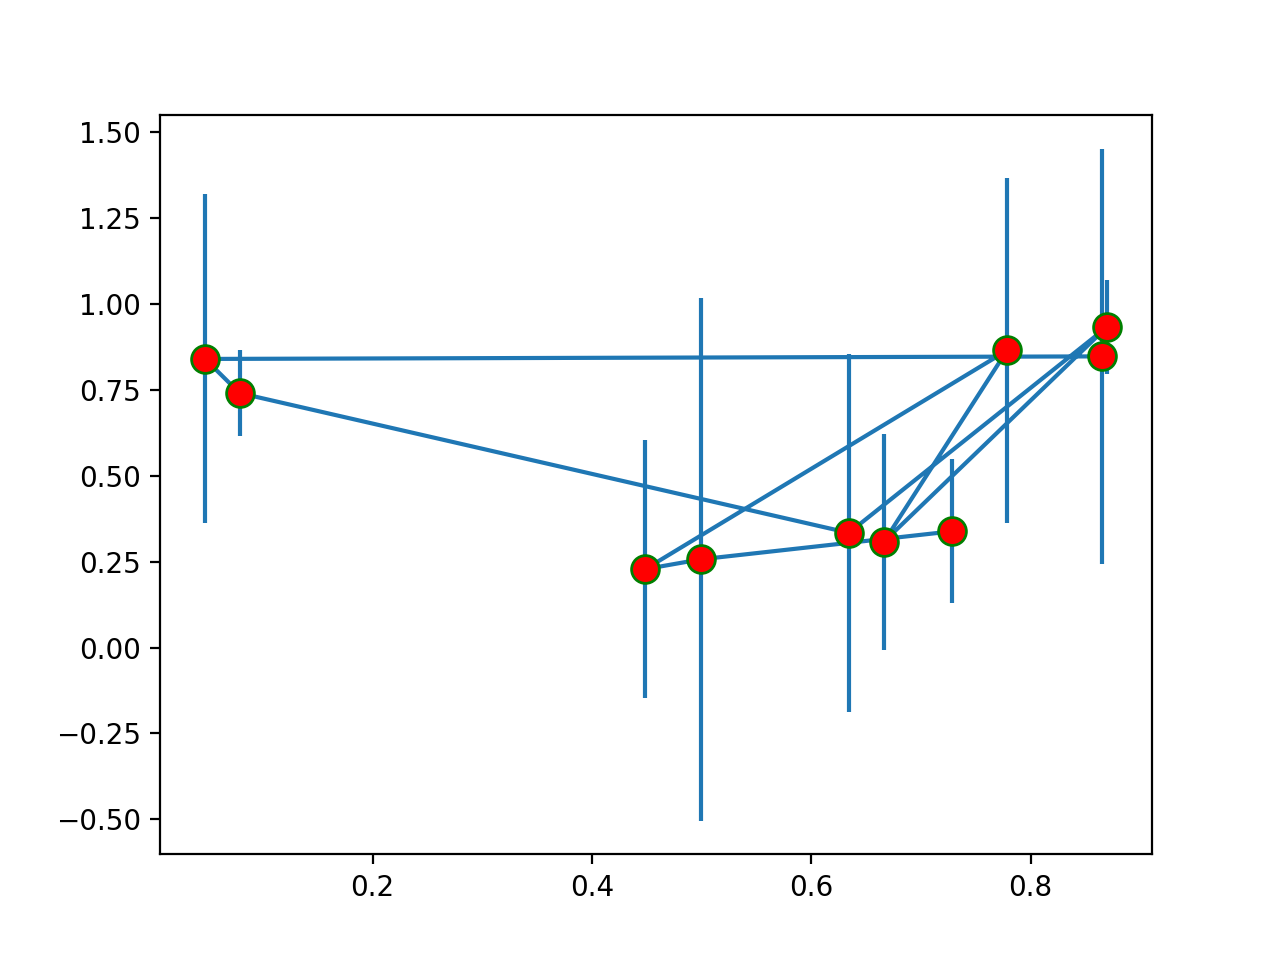

<ErrorbarContainer object of 3 artists>

In [14]:
%matplotlib notebook

x,y,yerr = np.random.rand(3,10)
plt.errorbar(x, y, yerr, marker='o', mfc='red',
         mec='green', ms=10)#, mew=2)